In [19]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
from textblob import TextBlob
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [20]:
url = "https://en.wikipedia.org/wiki/Bangladesh"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract plain text from paragraphs
paragraphs = soup.find_all('p')
text = ' '.join([para.get_text() for para in paragraphs])
print(text[:1000])



 Bangladesh,[a] officially the People's Republic of Bangladesh,[b] is a country in South Asia. It is the eighth-most populous country in the world and among the most densely populated with a population of over 171 million within an area of 148,460 square kilometres (57,320 sq mi). Bangladesh shares land borders with India to the north, west, and east, and Myanmar to the southeast. It has a coastline along the Bay of Bengal to its south and is separated from Bhutan and Nepal by the Siliguri Corridor, and from China by the Indian state of Sikkim to its north. Dhaka, the capital and largest city, is the nation's political, financial, and cultural centre. Chittagong is the second-largest city and the busiest port of the country. 
 The territory of modern Bangladesh was a stronghold of many Buddhist and Hindu dynasties in ancient history. Following the Muslim conquest in 1204, the Sultanate and Mughal periods saw the region's transformation into one of the wealthiest in the world. The Batt

In [21]:
text = re.sub(r'\[.*?\]', '', text)  # Remove [x] citations
text = re.sub(r'\s+', ' ', text)     # Normalize whitespace
text = text.strip()


In [22]:
sentences = nltk.sent_tokenize(text)

df = pd.DataFrame(sentences, columns=['Sentence'])
df['Polarity'] = df['Sentence'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment'] = df['Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')
df.head()


,Sentence,Polarity,Sentiment
0,"Bangladesh, officially the People's Republic o...",0.000000,Neutral
1,It is the eighth-most populous country in the ...,0.500000,Positive
2,Bangladesh shares land borders with India to t...,0.000000,Neutral
3,It has a coastline along the Bay of Bengal to ...,0.000000,Neutral
4,"Dhaka, the capital and largest city, is the na...",0.033333,Positive


In [23]:
words = word_tokenize(text.lower())
words = [w for w in words if w.isalpha()]
filtered_words = [w for w in words if w not in stopwords.words('english')]

word_freq = Counter(filtered_words)
print(word_freq.most_common(10))


[('bangladesh', 169), ('country', 51), ('world', 41), ('bengal', 37), ('bengali', 36), ('include', 34), ('largest', 28), ('pakistan', 28), ('government', 27), ('dhaka', 25)]


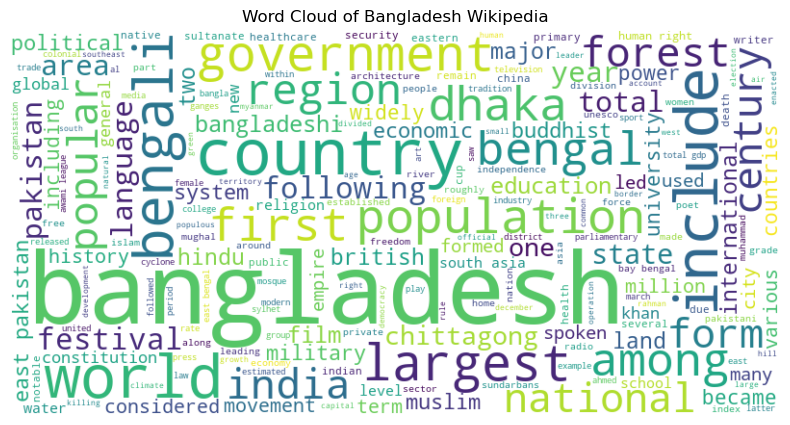

In [24]:
wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Bangladesh Wikipedia')
plt.show()


In [25]:
# Step 6: Create a dataframe of all sentences and sentiments (positive, negative, neutral)
sentiment_df_all = pd.DataFrame({
    'Sentence': sentences,
    'Polarity': [TextBlob(s).sentiment.polarity for s in sentences]
})

# Assign sentiment label based on polarity
def get_sentiment(p):
    if p > 0:
        return 'Positive'
    elif p < 0:
        return 'Negative'
    else:
        return 'Neutral'

sentiment_df_all['Sentiment'] = sentiment_df_all['Polarity'].apply(get_sentiment)

# Display stats
print(f"Total Sentences: {len(sentiment_df_all)}")
print("\nFirst 5 rows:")
print(sentiment_df_all.head())

# Count of each sentiment
print("\nSentiment Distribution:")
print(sentiment_df_all['Sentiment'].value_counts())

Total Sentences: 538

First 5 rows:
                                            Sentence  Polarity Sentiment
0  Bangladesh, officially the People's Republic o...  0.000000   Neutral
1  It is the eighth-most populous country in the ...  0.500000  Positive
2  Bangladesh shares land borders with India to t...  0.000000   Neutral
3  It has a coastline along the Bay of Bengal to ...  0.000000   Neutral
4  Dhaka, the capital and largest city, is the na...  0.033333  Positive

Sentiment Distribution:
Sentiment
Neutral     240
Positive    220
Negative     78
Name: count, dtype: int64


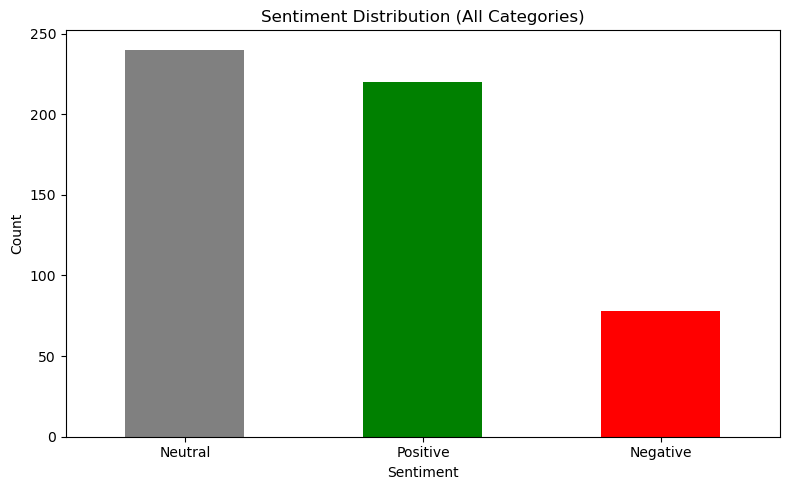

In [26]:
# Bar plot of sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_df_all['Sentiment'].value_counts().plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Sentiment Distribution (All Categories)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [27]:
df_binary = df[df['Sentiment'] != 'Neutral']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_binary['Sentence'])
y = df_binary['Sentiment'].map({'Positive': 1, 'Negative': 0})


In [28]:
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)


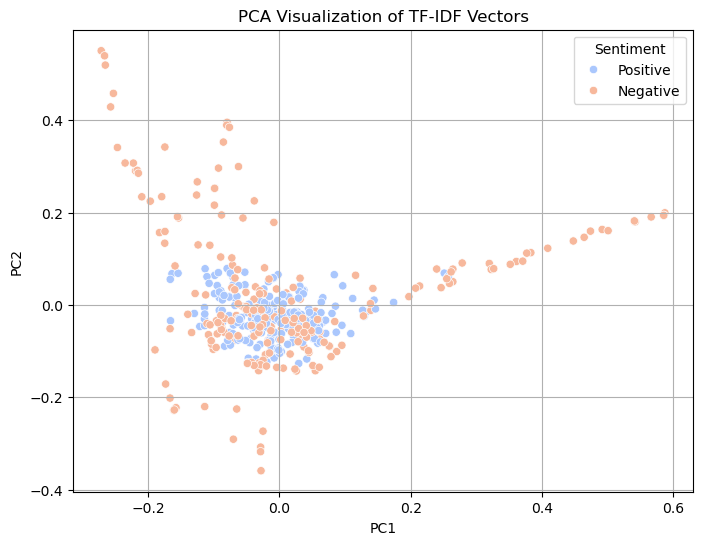

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bal.toarray())

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Sentiment'] = y_bal.replace({0: 'Negative', 1: 'Positive'})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Sentiment', palette='coolwarm')
plt.title("PCA Visualization of TF-IDF Vectors")
plt.grid(True)
plt.show()


In [30]:
# Top 20 frequent words
word_freq = Counter(filtered_words)
common_words = word_freq.most_common(20)

print("Top 20 Frequent Words:")
for word, count in common_words:
    print(f"{word}: {count}")


Top 20 Frequent Words:
bangladesh: 169
country: 51
world: 41
bengal: 37
bengali: 36
include: 34
largest: 28
pakistan: 28
government: 27
dhaka: 25
among: 24
east: 24
first: 24
population: 22
total: 22
national: 22
india: 19
popular: 19
south: 18
region: 18


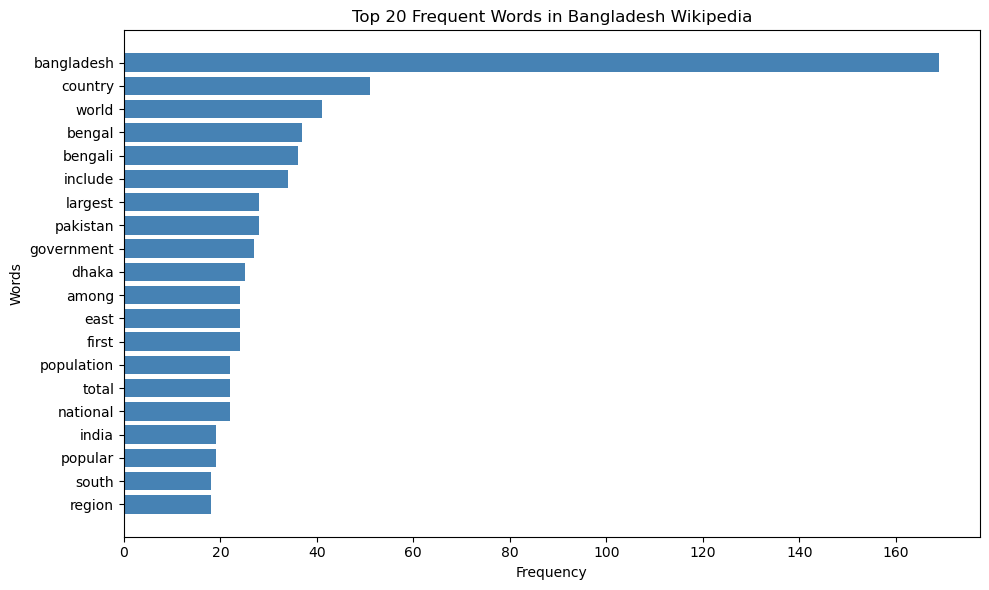

In [31]:
# Convert to DataFrame for plotting
words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Horizontal Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(words_df['Word'], words_df['Count'], color='steelblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Frequent Words in Bangladesh Wikipedia')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [32]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name} Accuracy: {acc:.2f}")
    print(model,":\n", classification_report(y_test, model.predict(X_test)))

Logistic Regression Accuracy: 0.88
LogisticRegression(max_iter=1000) :
               precision    recall  f1-score   support

           0       0.90      0.84      0.87        43
           1       0.85      0.91      0.88        45

    accuracy                           0.88        88
   macro avg       0.88      0.87      0.87        88
weighted avg       0.88      0.88      0.87        88

Decision Tree Accuracy: 0.83
DecisionTreeClassifier() :
               precision    recall  f1-score   support

           0       0.85      0.79      0.82        43
           1       0.81      0.87      0.84        45

    accuracy                           0.83        88
   macro avg       0.83      0.83      0.83        88
weighted avg       0.83      0.83      0.83        88

Random Forest Accuracy: 0.90
RandomForestClassifier() :
               precision    recall  f1-score   support

           0       1.00      0.79      0.88        43
           1       0.83      1.00      0.91        

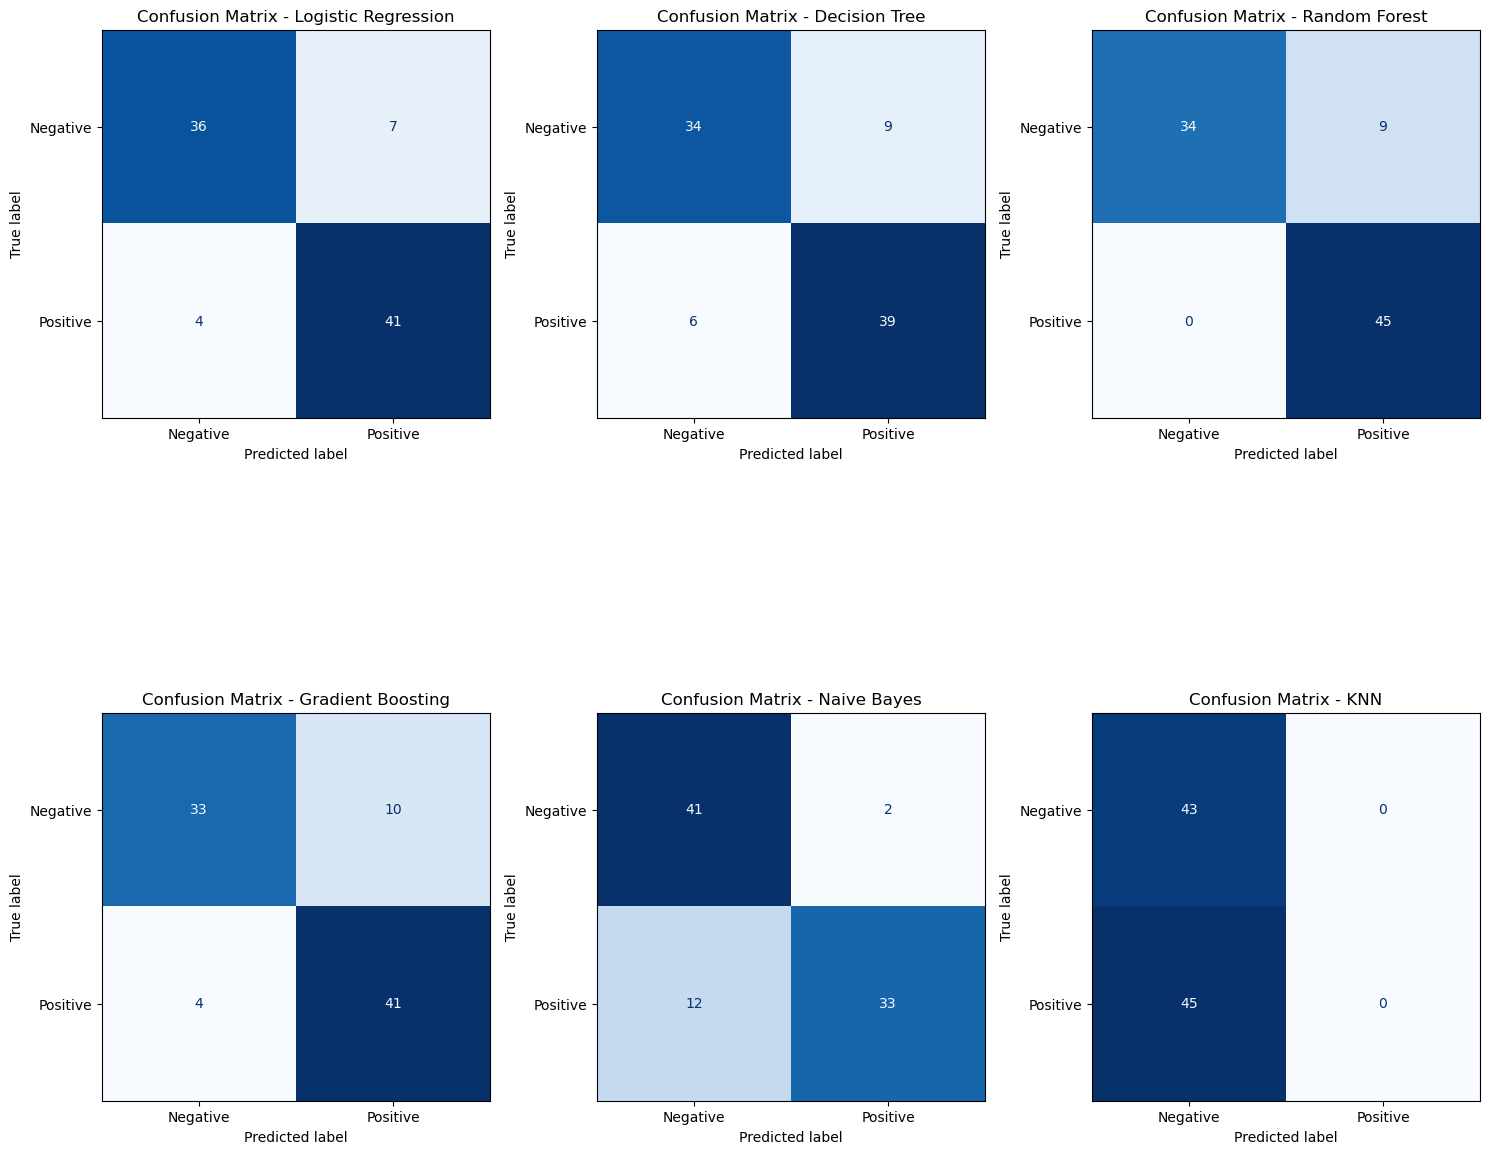

In [33]:
# Create subplot grid: 3 rows, 2 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
axes = axes.flatten()  # Flatten to 1D list for easy iteration

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"Confusion Matrix - {name}")
    axes[i].grid(False)

# Hide any unused subplots (in case < 6 models)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
